<div class="usecase-title">Pedestrian Accidents and Bus Stops</div>

<div class="usecase-authors"><b>Author: </b>Alison Collins</div>


<div class="usecase-duration"><b>Duration:</b> 90 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python, Data Preprocessing, Data Analysis, Modelling</div>
</div>

<div class="usecase-section-header">Scenario</div>

1. As a city planner, when considering bus stop locations and pedestrian safety, I want to identify if there is a relationship between bus stop locations and pedestrian accidents.

2. As a business owner, I want to visualise the potential of foot traffic against bus stops, to assist in decision making of new business locations.


<div class="usecase-section-header">What this use case will teach you</div>

At the end of this use case you will:
- Import data using API v2.1 GET request with /exports extension
- Import libraries, check for missing /null values in order to have a clean dataset
- Data visualisation by using matplotlib, dataframes, Geopandas
- Convert between Geodataframes and dataframes
- Use Geopandas to take subsamples of Geodataframes
- Allow user input
- Resample dataframes using date_time
- Mapping with folium incuding custom markers
- Oversampling, Undersampling and bootstrap approaches for imbalanced data classes
- Predictive modelling with Logistic Regression and Random Forest
- Understand results of confusion matrix, accuracy score and classification reports

<div class="usecase-section-header">Background</div>

Imagine the vibrant city of Melbourne grappling with the dual challenges of urban mobility and pedestrian flow. As the city evolves, so does the need for a transit system that not only efficiently moves people but also integrates seamlessly with the bustling pedestrian life. With the growing population, this city needs extensive mode of transportation network for the public; so isn't it important to understand the relationship between the bus-stops and pedestrains counts? </br>

To address this challenge, this study delves into the relationship between bus stops and pedestrian counts. The objective is to understand spatial and temporal patterns, identifying if there are areas where pedestrian activity peaks in conjunction with bus arrivals. This analysis becomes imperative to enhance urban planning. By optimizing this symbiotic relationship, the scenario aims to create a more seamless and efficient urban environment, improving both public transportation and the pedestrian experience in the heart of Melbourne.


<div class="usecase-section-header">Relevant Datasets</div>

[Bus Stops](https://data.melbourne.vic.gov.au/explore/dataset/bus-stops/information/)

- This dataset shows the Melbourne City Bus Stop locations. For this investigation, the most important  columns are those that hold the geographical position of the bus stop. This dataset is imported from Melbourne Open Data website, using a GET request with /export/ extension, from API V2.1.

[Pedestrian Counting System (counts per hour)](https://data.melbourne.vic.gov.au/explore/dataset/pedestrian-counting-system-monthly-counts-per-hour/information/)
- The city of Melbourne has been fitted with sensors across it's area. The sensors are fixed and count the motion throught the zone in multidirections <a href="#fn-1">[1]</a> to monotor pedestrian movement. This data is in this set is collated hourly and includes an interger measurement value of motion in each direction as well as a toal. The geographica location of each sensot is included and can be used to join this dataset with the bus stop dataset. This dataset is imported from Melbourne Open Data website, using a GET request with /export/ extension, from API V2.1.

### REQUIRED MODULES

In [1]:
# Dependencies
import warnings
warnings.filterwarnings("ignore")

import requests
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
from io import StringIO

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
import scikitplot as skplt
import plotly.express as px

from geopy.distance import geodesic

### IMPORT DATASETS

In [2]:
#Function to collect data using API v 2.1
def collect_data(dataset_id):
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    #apikey = api_key #use if use datasets API_key permissions
    dataset_id = dataset_id
    format = 'csv'

    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,  # all records
        'lang': 'en',
        'timezone': 'UTC',
        #'api_key': apikey  #use if datasets require API_key permissions
    }

    # GET request
    response = requests.get(url, params=params)

    if response.status_code == 200:
        # StringIO to read the CSV data
        url_content = response.content.decode('utf-8')
        dataset = pd.read_csv(StringIO(url_content), delimiter=';')
        return dataset
    else:
        print(f'Request failed with status code {response.status_code}')

In [3]:
# IMPORT BUS STOPS DATASET
# Set dataset_id to query for the API call dataset name
dataset_id = 'bus-stops'
# Save dataset to df varaible
bus_data = collect_data(dataset_id)
# Check number of records in df
print(f'The dataset contains {len(bus_data)} records.')
# View df
bus_data.head(3)

The dataset contains 309 records.


,geo_point_2d,geo_shape,prop_id,addresspt1,addressp_1,asset_clas,asset_type,objectid,str_id,addresspt,asset_subt,model_desc,mcc_id,roadseg_id,descriptio,model_no
0,"-37.80384165792465, 144.93239283833262","{""coordinates"": [144.93239283833262, -37.80384...",0,76.819824,357,Signage,Sign - Public Transport,355,1235255,570648,NaN,Sign - Public Transport 1 Panel,1235255,21673,Sign - Public Transport 1 Panel Bus Stop Type 13,P.16
1,"-37.81548699581418, 144.9581794249902","{""coordinates"": [144.9581794249902, -37.815486...",0,21.561304,83,Signage,Sign - Public Transport,600,1231226,548056,NaN,Sign - Public Transport 1 Panel,1231226,20184,Sign - Public Transport 1 Panel Bus Stop Type 8,P.16
2,"-37.81353897396532, 144.95728334230756","{""coordinates"": [144.95728334230756, -37.81353...",0,42.177187,207,Signage,Sign - Public Transport,640,1237092,543382,NaN,Sign - Public Transport 1 Panel,1237092,20186,Sign - Public Transport 1 Panel Bus Stop Type 8,P.16


In [4]:
# URL to the GeoJSON file
url = 'https://vicroadsopendatastorehouse.vicroads.vic.gov.au/opendata/Road_Safety/VICTORIAN_ROAD_CRASH_DATA.geojson'

# Set the User-Agent to mimic a browser request
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}

# Make the HTTP request
response = requests.get(url, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    # Load GeoJSON data into a pandas DataFrame
    data = response.json()
    features = data['features']
    properties_data = [feature['properties'] for feature in features]
    crash_data = pd.DataFrame(properties_data)
    print(f'The dataset contains {len(crash_data)} records.')
else:
    print(f'Failed to retrieve data: {response.status_code}')

# View df
crash_data.head(3)

The dataset contains 167043 records.


,ACCIDENT_NO,ACCIDENT_DATE,ACCIDENT_TIME,ACCIDENT_TYPE,DAY_OF_WEEK,DCA_CODE,LIGHT_CONDITION,POLICE_ATTEND,ROAD_GEOMETRY,SEVERITY,SPEED_ZONE,RUN_OFFROAD,NODE_ID,NODE_TYPE,LGA_NAME,LATITUDE,LONGITUDE,VICGRID_X,VICGRID_Y,TOTAL_PERSONS,INJ_OR_FATAL,FATALITY,SERIOUSINJURY,OTHERINJURY,NONINJURED,MALES,FEMALES,BICYCLIST,PASSENGER,DRIVER,PEDESTRIAN,PILLION,MOTORCYCLIST,UNKNOWN,PED_CYCLIST_5_12,PED_CYCLIST_13_18,OLD_PED_65_AND_OVER,OLD_DRIVER_75_AND_OVER,YOUNG_DRIVER_18_25,NO_OF_VEHICLES,HEAVYVEHICLE,PASSENGERVEHICLE,MOTORCYCLE,PT_VEHICLE,DEG_URBAN_NAME,SRNS,RMA,DIVIDED,STAT_DIV_NAME
0,T20120000009,20120101,022500,Collision with a fixed object,Sunday,LEFT OFF CARRIAGEWAY INTO OBJECT/PARKED VEHICLE,Dark No street lights,Yes,Not at intersection,Other injury accident,100 km/hr,Yes,249102,Non-Intersection,BAW BAW,-38.234957,145.726709,2563628.962,2362700.434,2,2,0,0,2,0,2,0,0,1,1,0,0,0,0,0,0,0,0,1,1.0,0.0,1.0,0.0,0.0,RURAL_VICTORIA,C,Arterial Other,Undivided,Country
1,T20120000012,20120101,020000,Collision with vehicle,Sunday,CROSS TRAFFIC(INTERSECTIONS ONLY),Dark Street lights on,Yes,Cross intersection,Serious injury accident,80 km/hr,No,41780,Non-Intersection,MONASH,-37.903541,145.161404,2514194.683,2399718.586,3,1,0,1,0,2,2,0,0,1,2,0,0,0,0,0,0,0,0,0,2.0,0.0,2.0,0.0,0.0,MELB_URBAN,None,Arterial Highway,Divided,Metro
2,T20120000013,20120101,033500,Collision with vehicle,Sunday,VEHICLE COLLIDES WITH VEHICLE PARKED ON LEFT O...,Dark Street lights on,Yes,T intersection,Serious injury accident,60 km/hr,No,69811,Intersection,KINGSTON,-37.935940,145.098848,2508689.410,2396130.003,1,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2.0,0.0,2.0,0.0,0.0,MELB_URBAN,None,Arterial Other,Undivided,Metro


### DATASET PREPROCESSING

#### Bus Stop Data

Check columns and delete those not needed for analysis. Check for null vlaues and delete any rows with missing values. Check data types in columns.

In [147]:
# Check the names of the columns
column_names = bus_data.columns.tolist()
print("\033[1mColumn names:\033[0m")
print(column_names)

Column names:
['geo_point_2d', 'geo_shape', 'prop_id', 'addresspt1', 'addressp_1', 'asset_clas', 'asset_type', 'objectid', 'str_id', 'addresspt', 'asset_subt', 'model_desc', 'mcc_id', 'roadseg_id', 'descriptio', 'model_no']


In [148]:
# Drop the unnesccessary columns, save back to bus variable
bus = bus_data[["geo_shape","addresspt1","asset_type","str_id"]]

# Rename str_id to stop_name
bus.rename(columns={'str_id': 'stop_name'}, inplace=True)

# Extract latitude and longitude from geo_shape
bus['coordinates'] = bus['geo_shape'].apply(lambda x: eval(x)['coordinates'])
bus[['longitude', 'latitude']] = pd.DataFrame(bus['coordinates'].tolist(), index=bus.index)
bus.head(2)

,geo_shape,addresspt1,asset_type,stop_name,coordinates,longitude,latitude
0,"{""coordinates"": [144.93239283833262, -37.80384...",76.819824,Sign - Public Transport,1235255,"[144.93239283833262, -37.80384165792465]",144.932393,-37.803842
1,"{""coordinates"": [144.9581794249902, -37.815486...",21.561304,Sign - Public Transport,1231226,"[144.9581794249902, -37.81548699581418]",144.958179,-37.815487


In [149]:
# Check for null values
print("\033[1mNaN Value in Bus-stop Data:\033[0m")
print(bus.isna().sum())

NaN Value in Bus-stop Data:
geo_shape      0
addresspt1     0
asset_type     0
stop_name      0
coordinates    0
longitude      0
latitude       0
dtype: int64


In [150]:
# Check data types
print("\033[1m\nData Types in Bus-stop Data:\033[0m")
print(bus.dtypes)


Data Types in Bus-stop Data:
geo_shape       object
addresspt1     float64
asset_type      object
stop_name        int64
coordinates     object
longitude      float64
latitude       float64
dtype: object


In [188]:
# Select only rows within specified geographical area
bus_int = bus[(bus['latitude'] > -37.82106) & (bus['latitude'] <= -37.80003)]
bus_city = bus_int[(bus_int['longitude'] > 144.9501) & (bus_int['longitude'] <= 144.96103)]

# Check number of records in df
print(f'The dataset contains {len(bus_city)} records.')
# View df
bus_city.head(3)

The dataset contains 55 records.


,geo_shape,addresspt1,asset_type,stop_name,coordinates,longitude,latitude
1,"{""coordinates"": [144.9581794249902, -37.815486...",21.561304,Sign - Public Transport,1231226,"[144.9581794249902, -37.81548699581418]",144.958179,-37.815487
2,"{""coordinates"": [144.95728334230756, -37.81353...",42.177187,Sign - Public Transport,1237092,"[144.95728334230756, -37.81353897396532]",144.957283,-37.813539
9,"{""coordinates"": [144.95370614040704, -37.81249...",16.143764,Sign - Public Transport,1253565,"[144.95370614040704, -37.812490976626215]",144.953706,-37.812491


#### Crash Data

Check columns and delete those not needed for analysis. Select only the data where pedestrians were involved in accidents. Check for null vlaues and delete any rows with missing values. Check data types in columns.

In [152]:
# Check the names of the columns
column_names = crash_data.columns.tolist()
print(column_names)

['ACCIDENT_NO', 'ACCIDENT_DATE', 'ACCIDENT_TIME', 'ACCIDENT_TYPE', 'DAY_OF_WEEK', 'DCA_CODE', 'LIGHT_CONDITION', 'POLICE_ATTEND', 'ROAD_GEOMETRY', 'SEVERITY', 'SPEED_ZONE', 'RUN_OFFROAD', 'NODE_ID', 'NODE_TYPE', 'LGA_NAME', 'LATITUDE', 'LONGITUDE', 'VICGRID_X', 'VICGRID_Y', 'TOTAL_PERSONS', 'INJ_OR_FATAL', 'FATALITY', 'SERIOUSINJURY', 'OTHERINJURY', 'NONINJURED', 'MALES', 'FEMALES', 'BICYCLIST', 'PASSENGER', 'DRIVER', 'PEDESTRIAN', 'PILLION', 'MOTORCYCLIST', 'UNKNOWN', 'PED_CYCLIST_5_12', 'PED_CYCLIST_13_18', 'OLD_PED_65_AND_OVER', 'OLD_DRIVER_75_AND_OVER', 'YOUNG_DRIVER_18_25', 'NO_OF_VEHICLES', 'HEAVYVEHICLE', 'PASSENGERVEHICLE', 'MOTORCYCLE', 'PT_VEHICLE', 'DEG_URBAN_NAME', 'SRNS', 'RMA', 'DIVIDED', 'STAT_DIV_NAME']


In [153]:
# Select only the rows where pedestrians are involved
crash = crash_data.drop(crash_data[crash_data['PEDESTRIAN'] == 0].index)

# Drop the unnesccessary columns, save back to bus variable
crash = crash[["ACCIDENT_NO","ACCIDENT_DATE","ACCIDENT_TIME","PEDESTRIAN","SEVERITY","LATITUDE","LONGITUDE"]]

# Rename columns to lowercase
crash.columns = [col.lower() for col in crash.columns]

crash.head(2)

,accident_no,accident_date,accident_time,pedestrian,severity,latitude,longitude
6,T20120000032,20120101,005500,1,Other injury accident,-37.841733,144.953222
9,T20120000046,20120101,162500,1,Other injury accident,-38.367171,144.877550


In [154]:
# Check for null values in crash data
print("\033[1m\nNaN Values in Crash Data:\033[0m")
print(crash.isna().sum())


NaN Values in Crash Data:
accident_no      0
accident_date    0
accident_time    0
pedestrian       0
severity         0
latitude         0
longitude        0
dtype: int64


In [155]:
# Convert the date and time columns to strings
crash['accident_date'] = crash['accident_date'].astype(str)
crash['accident_time'] = crash['accident_time'].astype(str)

# Combine accident date and time to make a timestamp column
crash['timestamp'] = pd.to_datetime(crash['accident_date'] + ' ' + crash['accident_time'], format='mixed')

crash.head(2)

,accident_no,accident_date,accident_time,pedestrian,severity,latitude,longitude,timestamp
6,T20120000032,20120101,005500,1,Other injury accident,-37.841733,144.953222,2012-01-01 00:55:00
9,T20120000046,20120101,162500,1,Other injury accident,-38.367171,144.877550,2012-01-01 16:25:00


In [156]:
unique_values = crash['severity'].unique()
print(unique_values)

['Other injury accident' 'Serious injury accident' 'Fatal accident']


In [157]:
unique_values = crash['pedestrian'].unique()
print(unique_values)

[1 2 3 5 4 6 7 9]


In [158]:
# Check data types
print("\033[1m\nData Types in Crash Data:\033[0m")
print(crash.dtypes)


Data Types in Crash Data:
accident_no              object
accident_date            object
accident_time            object
pedestrian                int64
severity                 object
latitude                float64
longitude               float64
timestamp        datetime64[ns]
dtype: object


In [189]:
# Select only rows within specified gerograhical area
crash_int = crash[(crash['latitude'] > -37.82106) & (crash['latitude'] <= -37.80003)]
crash_city = crash_int[(crash_int['longitude'] > 144.9501) & (crash_int['longitude'] <= 144.96103)]

# Check number of records in df
print(f'The dataset contains {len(crash_city)} records.')
# View df
bus_city.head(3)

The dataset contains 345 records.


,geo_shape,addresspt1,asset_type,stop_name,coordinates,longitude,latitude
1,"{""coordinates"": [144.9581794249902, -37.815486...",21.561304,Sign - Public Transport,1231226,"[144.9581794249902, -37.81548699581418]",144.958179,-37.815487
2,"{""coordinates"": [144.95728334230756, -37.81353...",42.177187,Sign - Public Transport,1237092,"[144.95728334230756, -37.81353897396532]",144.957283,-37.813539
9,"{""coordinates"": [144.95370614040704, -37.81249...",16.143764,Sign - Public Transport,1253565,"[144.95370614040704, -37.812490976626215]",144.953706,-37.812491


### EXPLORATORY DATA ANALYSIS

#### Crash Data

Count the number of accidents occurring on each day and display in a temporal graph.

In [160]:
# Group the data by the date and count the rows for each date, make new dataframe
date_counts = crash_city.groupby(crash['timestamp'].dt.date).size().reset_index(name='count')

# Rename the columns for clarity
date_counts.columns = ['date', 'count']

# Check number of records in df
print(f'The dataset contains {len(date_counts)} records.')
# Display df
date_counts.head(3)

The dataset contains 331 records.


,date,count
0,2012-01-05,1
1,2012-01-08,1
2,2012-01-10,1


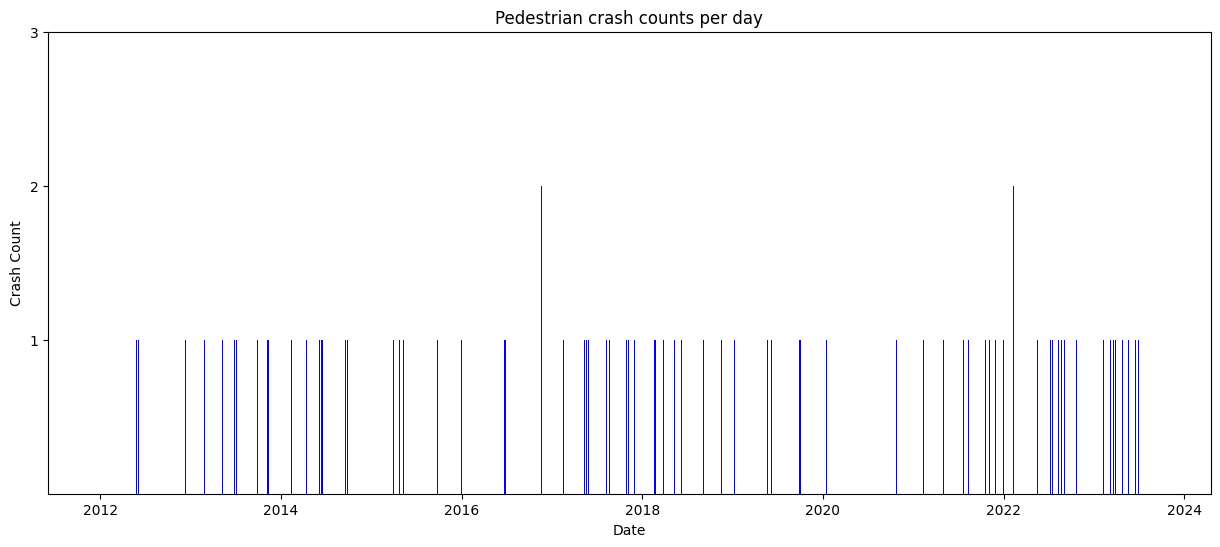

In [161]:
# Plot temporal patterns in pedestrian counts at alll locations
plt.rcParams['figure.figsize'] = [15, 6]
plt.bar(date_counts['date'], date_counts['count'], color='blue')
plt.title('Pedestrian crash counts per day')
plt.xlabel('Date')
plt.ylabel('Crash Count')
# Set custom y-axis values
y_ticks = [1,2,3]
plt.yticks(ticks=y_ticks)
plt.show()

Temporal patterns in crash data shows that the dataset is over 12 years. The maximum number of crashes is 15, with many days at 0 recorded crashes. 

A view of both the of locations of accidents and bus stop locations at the same time allows investgation of if there is overlap between these datasets.

In [190]:
# Create GeoDataFrames
gdf_bus = gpd.GeoDataFrame(bus_city, geometry=gpd.points_from_xy(bus_city['latitude'], bus_city['longitude']))

gdf_crash = gpd.GeoDataFrame(crash_city, geometry=gpd.points_from_xy(crash_city['latitude'], crash_city['longitude']))

In [191]:
# Initialize the map at Melbourne and store it in a m object
m = folium.Map(location = [-37.815, 144.96],zoom_start = 14)

# Add a circle marker for each accident location  
for i in range(0,len(gdf_crash)):
    folium.Circle(
        location=[gdf_crash.iloc[i]['latitude'], gdf_crash.iloc[i]['longitude']],
        radius=50,
        color='red',
        fill_color='red'
   ).add_to(m)
    
# Add a circle marker for each bus stop location
for i in range(0,len(gdf_bus)):
    folium.Circle(
        location=[gdf_bus.iloc[i]['latitude'], gdf_bus.iloc[i]['longitude']],
        radius=50,
        color='black',
        fill_color='black'
   ).add_to(m)

# Title for map
m.get_root().html.add_child(folium.Element("<h3 align='center'>Locations of Pedestrian Accidents Bus Stop Location</h3>"))

m

This map shows the locations of bus stops and accidents. It can be seen that in the centra melbourne area were many accidents occurring in the 

In [192]:
# Plot treemap of bus stop and non bus stop counts
fig = px.treemap(crash_city, path=['severity'], width=800, height=400, title="Total accidents by classification of type", color="severity", 
    color_discrete_map={
        "Other injury accident": "lightyellow",
        "Serious injury accident": "orange",
        "Fatal accident": "red"
    })
fig.show()

In [165]:
# Types of accidents
other = crash_city.loc[crash_city['severity'] == 'Other injury accident']
severe = crash_city.loc[crash_city['severity'] == 'Serious injury accident']
fatal = crash_city.loc[crash_city['severity'] == 'Fatal accident']

# Create GeoDataFrames from types of accidents
gdf_other = gpd.GeoDataFrame(other, geometry=gpd.points_from_xy(other['latitude'], other['longitude']))
gdf_severe = gpd.GeoDataFrame(severe, geometry=gpd.points_from_xy(severe['latitude'], severe['longitude']))
gdf_fatal = gpd.GeoDataFrame(fatal, geometry=gpd.points_from_xy(fatal['latitude'], fatal['longitude']))

In [178]:
# Initialize the map at Melbourne and store it in a m object
m = folium.Map(location = [-37.815, 144.96],zoom_start = 14)

# Add pedestrian numbers at locations without bus stops
for i in range(0,len(gdf_other)):
   folium.Circle(
      location=[gdf_other.iloc[i]['latitude'], gdf_other.iloc[i]['longitude']],
      radius=50,
      color='yellow',
      fill_color='yellow'
   ).add_to(m)
   
# Add pedestrian numbers at locations with bus stops
for i in range(0,len(gdf_severe)):
   folium.Circle(
      location=[gdf_severe.iloc[i]['latitude'], gdf_severe.iloc[i]['longitude']],
      radius=50,
      color='orange',
      fill_color='orange'
   ).add_to(m)
   
# Add pedestrian numbers at locations with bus stops
for i in range(0,len(gdf_fatal)):
   folium.Circle(
      location=[gdf_fatal.iloc[i]['latitude'], gdf_fatal.iloc[i]['longitude']],
      radius=50,
      color='red',
      fill_color='red'
   ).add_to(m)

# Add a circle marker for each bus stop location
for i in range(0,len(gdf_bus)):
    folium.Circle(
        location=[gdf_bus.iloc[i]['latitude'], gdf_bus.iloc[i]['longitude']],
        radius=50,
        color='black',
        fill_color='black'
   ).add_to(m)
    
# Title for map
m.get_root().html.add_child(folium.Element("<h3 align='center'>Locations of accidents by type</h3>"))

# Show the map
m

It would be useful to have the ability to enter a date period and show the average pedestian numbers at each location.

### ANALYSIS OF PROXIMITY OF ACCIDENTS TO BUS STOPS

In [200]:
import geopandas as gpd
from shapely.geometry import Point


# Create a buffer around each bus stop in geodataframe (e.g., 100 meters)
buffer_radius = 0.0005
gdf_bus['buffer'] = gdf_bus['geometry'].buffer(buffer_radius)


In [201]:
# Initialize an empty list to store results
results = []

# Iterate through accidents
for _, accident_row in gdf_crash.iterrows():
    accident_point = accident_row['geometry']
    for _, bus_stop_row in gdf_bus.iterrows():
        bus_stop_buffer = bus_stop_row['buffer']
        if accident_point.within(bus_stop_buffer):
            results.append({
                'accident_id': accident_row['accident_no'],
                'bus_stop_buffer_area': bus_stop_row['stop_name']
            })

# Create a DataFrame from the results
result_df = pd.DataFrame(results)

# Check number of records in df
print(f'The dataset contains {len(result_df)} records.')
# Show df
result_df.head(2)

The dataset contains 281 records.


,accident_id,bus_stop_buffer_area
0,T20120000646,1247064
1,T20120000646,1268402


### ANALYSIS OF DISTANCE

Analyse distance between bus stops and from crash locations to closest bus stop.

In [169]:
# Function to calculate haversine distance between two pairs of geographhical locations
def haversine(lon1, lat1, lon2, lat2):
    R = 6371  
    # Earth's radius in kilometers
    dlon = np.radians(lon2 - lon1)
    dlat = np.radians(lat2 - lat1)
    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance


#### Between Bus Stops

In [170]:
# Calculate distances between all pairs of bus stops
for i, row1 in bus_city.iterrows():
    min_distance = float("inf")
    next_closest_stop = None
    for j, row2 in bus_city.iterrows():
        if i != j:
            dist = haversine(row1["latitude"], row1["longitude"], row2["latitude"], row2["longitude"])
            if dist < min_distance:
                min_distance = dist
                next_closest_stop = row2["stop_name"]
    bus_city.loc[i, "next_closest_stop"] = next_closest_stop
    bus_city.loc[i, "distance_to_stop"] = min_distance

# Convert next closest stop to int
bus_city['next_closest_stop'] = bus_city['next_closest_stop'].astype(int)

# Show df
bus_city.head(2)

,geo_shape,addresspt1,asset_type,stop_name,coordinates,longitude,latitude,next_closest_stop,distance_to_stop
1,"{""coordinates"": [144.9581794249902, -37.815486...",21.561304,Sign - Public Transport,1231226,"[144.9581794249902, -37.81548699581418]",144.958179,-37.815487,1236808,0.035341
2,"{""coordinates"": [144.95728334230756, -37.81353...",42.177187,Sign - Public Transport,1237092,"[144.95728334230756, -37.81353897396532]",144.957283,-37.813539,1231223,0.033488


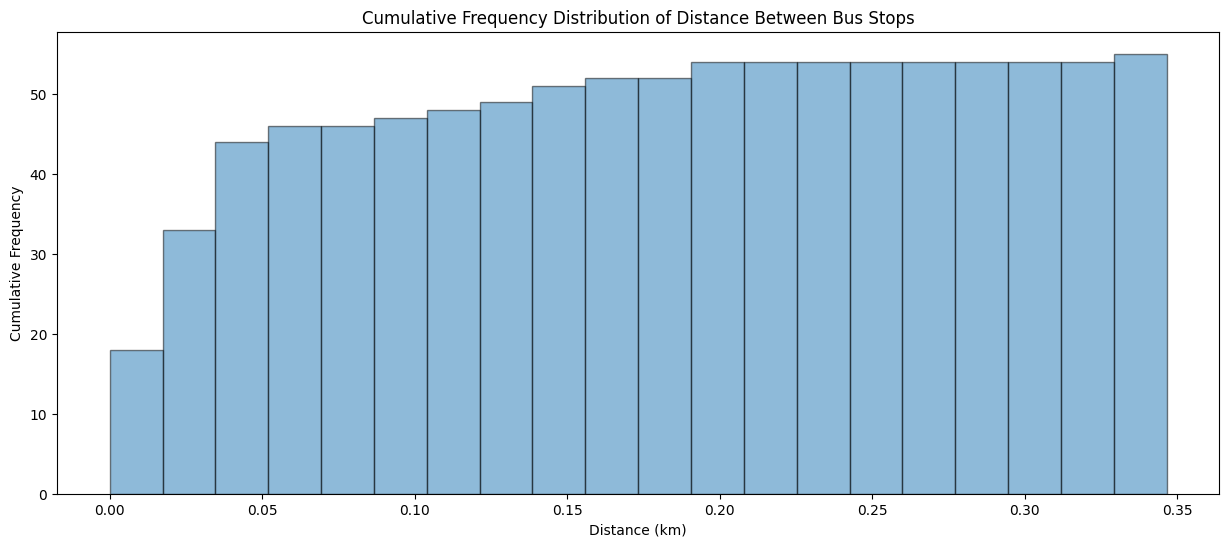

In [171]:
# Create a cumulative frequency histogram
bus_city['distance_to_stop'].plot.hist(bins=20, cumulative=True, edgecolor='black', alpha=0.5)
plt.xlabel('Distance (km)')
plt.ylabel('Cumulative Frequency')
plt.title('Cumulative Frequency Distribution of Distance Between Bus Stops')
plt.show()

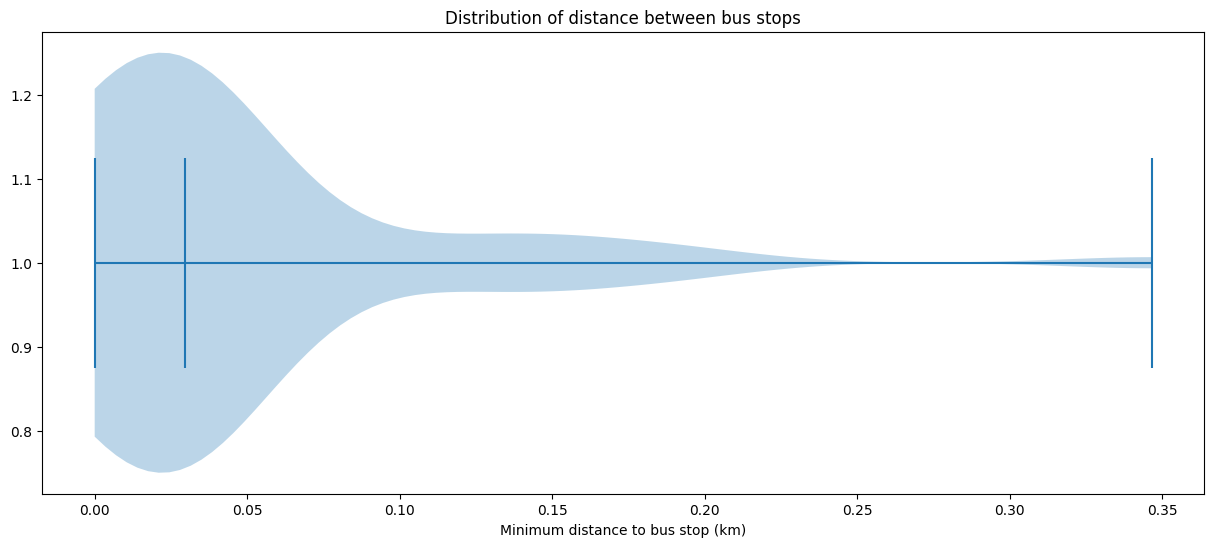

In [172]:
# Call violin plot on distance from bus stop to bus stop
plt.violinplot(bus_city['distance_to_stop'], showmedians=True, vert=False)
# Set plot labels and title
plt.title("Distribution of distance between bus stops")
plt.xlabel('Minimum distance to bus stop (km)')
plt.show()

#### From Crash Locations to Bus Stops

In [173]:
# Apply haversine function
# Initiate new column in crash city data
crash_city['min_dist'] = np.inf

# Loop calculating closest distance to bus stop from accident location
for _, row1 in bus_city.iterrows():
    for _, row2 in crash_city.iterrows():
        dist = haversine(row1['longitude'], row1['latitude'], row2['longitude'], row2['latitude'])
        if dist < crash_city.loc[_, 'min_dist']:
            crash_city.loc[_, 'min_dist'] = dist
            crash_city.loc[_, 'min_bus_stop'] = row1['stop_name']

crash_city.head(2)

,accident_no,accident_date,accident_time,pedestrian,severity,latitude,longitude,timestamp,min_dist,min_bus_stop
92,T20120000296,20120105,153000,1,Serious injury accident,-37.80789,144.957949,2012-01-05 15:30:00,0.206581,1238699.0
171,T20120000506,20120108,131500,1,Other injury accident,-37.81939,144.957106,2012-01-08 13:15:00,0.121817,1268402.0


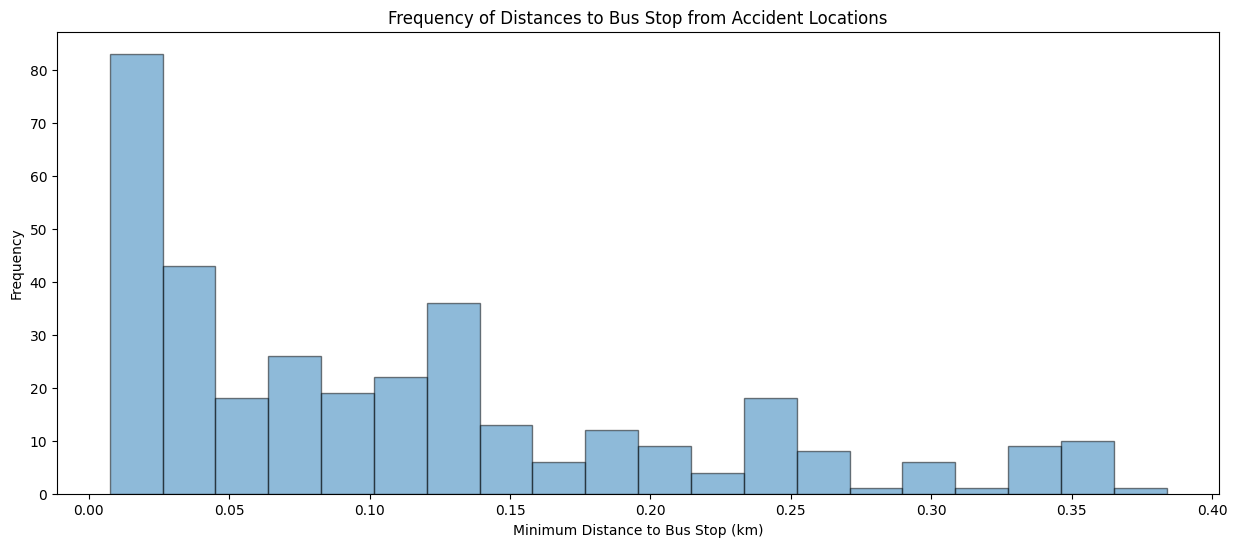

In [174]:
# Create a histogram
crash_city['min_dist'].plot(kind='hist', bins=20, edgecolor='black', alpha=0.5)
plt.xlabel('Minimum Distance to Bus Stop (km)')
plt.ylabel('Frequency')
plt.title('Frequency of Distances to Bus Stop from Accident Locations')
plt.show()

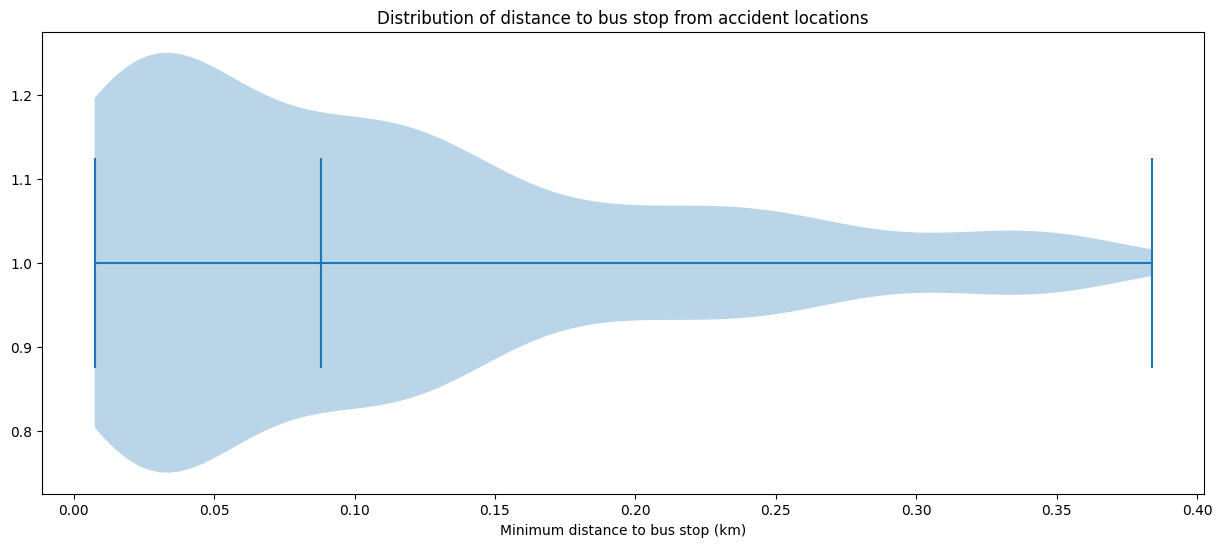

In [175]:
# Call violin plot on distance from crash location to bus stop
plt.violinplot(crash_city['min_dist'], showmedians=True, vert=False)
# Set plot labels and title
plt.title("Distribution of distance to bus stop from accident locations")
plt.xlabel('Minimum distance to bus stop (km)')
plt.show()

The analysis section of this use case aimed to determine if there are relationships between bus stop presence and the number of pedestrians at a location. From the data availible, it can be seen there are many more pedestrians at locations where there are no bus stops. Locations with no bus stops had higher mdeian values, higher means and higher maximum values that locations with bus stops. This pattern was seen throughout week days as well as across the months of the year. This use case also aimed to uncover temporal pattens in pedestrian numbers at bus stop and non-bus stop locations. The temporal patterns were unclear, due to a small date range in the pedestrian count datasets availible. As the pedestrian counts dataset grows in size overtime, clearer patterns may become evident.

The modelling section aimed to determine if there were strong relationships between pedestrian numbers and bus stop locations that could be used to predict bus stop locations. The main difficulty associated with this investigation was that there were few locations of overlap where bus stops and pedestrian counting occurred. Many places of pedestrain counting did not have a bus stop associated, thus making the dataset unequal in size of bus stop vs non-bus stop locations. To address this imbalance, methods of oversampling, undersampling and bootstrapping where appied to predictive modelling to determine if there was a relationship between the variables. All predictive models tested had results that do not suggest pedestrian numbers can be used to predict bus stop locations.

### FUTURE DIRECTIONS FOR RESEARCH

One of the locations of the highest number of pedestrians are seen to be at the Spencer Street Train Station entrance. It would be valuable to identify train station entry and exit points and investigate if there is a relationship between these locations across the city and the number of pedestrians. In addition, the Melbourne Cricket Ground (MCG) was also a location that was mapped as the top location for pedestrian traffic, so mapping numbers of pedestrians aginst events held at the MCG would also be a project to be considered. Another vein of investigation would be the mapping of pedestrians againt large events held in the city, including dates of concerts, sporting events and festivals.

### REFERENCES

<fn id="fn-1">[1]</fn> Melbourne City Council (2023) [Pedestrian Counting System - City of Melbourne](https://www.melbourne.vic.gov.au/about-melbourne/research-and-statistics/city-population/Pages/pedestrian-counting-system.aspx). City of Melbourne Council, Australia. 

<fn id="fn-2">[2]</fn> Jason Browne (2021) [Undersampling for Imbalanced Classification](https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/). Machine Learning Mastery, Guiding Tech Media. 

<fn id="fn-3">[3]</fn> Geeks For Geeks (2024) [Handling Imbalanced Data with SMOTE and Near Miss Algorithm in Python](https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/) GeeksforGeeks.

<fn id="fn-4">[4]</fn> Geeks For Geeks (2024) [Bagging and Random Forest for Imbalanced Classification](https://www.geeksforgeeks.org/bagging-and-random-forest-for-imbalanced-classification/). GeeksforGeeks. 
